In [240]:
import pandas as pd
import numpy as np

In [241]:
# read data
biomarker_clean = pd.read_csv('../data/biomarker_clean.csv')

In [242]:
# see column names
biomarker_clean.columns

Index(['Unnamed: 0', 'group', 'ados', 'CHIP', 'CEBPB', 'NSE', 'PIAS4',
       'IL-10 Ra', 'STAT3', 'IRF1',
       ...
       'UB2G2', 'Transgelin-2', 'ATPO', 'Corticotropin-lipotropin', 'QORL1',
       'PEDF', 'CATF', 'FTCD', 'UBP25', 'PLXB2'],
      dtype='object', length=1320)

In [243]:
# drop the unnamed column and ados
biomarker_clean = biomarker_clean.drop(['Unnamed: 0'], axis=1)

ADOS diagnostic algo- rithms consisting of two behavioral domains: Social Affect (SA) and Restricted and Repetitive Behaviors (RRB) were used to determine an ADOS total score, which provides a continuous measure of overall ASD symptom severity.

In [244]:
biomarker_clean[biomarker_clean['ados'].isna()]['group'].value_counts()

group
TD    78
Name: count, dtype: int64

In [245]:
biomarker_clean[biomarker_clean['ados'].notna()]['group'].value_counts()

group
ASD    76
Name: count, dtype: int64

# Binomial classification

In [246]:
biomarker_clean = biomarker_clean.drop(['ados'], axis=1)


In [247]:
biomarker_clean['group'] = biomarker_clean['group'].apply(lambda x: 1 if x == 'ASD' else 0).astype(int)

In [248]:
X = biomarker_clean.loc[:, 'CHIP':].to_numpy()
y = biomarker_clean.loc[:, 'group'].to_numpy()
X

array([[ 0.33500909,  0.52030255, -0.55429753, ...,  3.        ,
        -0.47723488, -1.23419401],
       [-0.07145438,  1.00627423,  3.        , ...,  0.78371039,
         0.13825367,  0.0952122 ],
       [-0.4060154 , -0.53103679, -0.05922125, ..., -1.14594023,
        -0.68955127,  0.83858575],
       ...,
       [ 0.03237458,  1.32008149, -0.24124172, ..., -0.10017329,
         0.49931348,  0.63298266],
       [ 0.19662737,  1.5288767 ,  0.36405519, ..., -0.23166439,
         0.65427786, -0.03871574],
       [ 1.24956203,  0.47847807,  3.        , ...,  1.66966352,
        -0.58197324,  1.52234164]])

In [249]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sklearn.utils.resample(*arrays, replace=True, n_samples=None, random_state=None, stratify=None)[source]
Resample arrays or sparse matrices in a consistent way.

The default strategy implements one step of the bootstrapping procedure.

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=197)

## Random Forest

In [251]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='gini',
                                  max_depth=15,
                                  min_samples_split=5,
                                  bootstrap=True,
                                  random_state=197)
rf_model.fit(X_train, y_train)
rf_feature_importance = rf_model.feature_importances_

In [252]:
rf_top_feature_importance_idx = np.argsort(rf_feature_importance)[-20:][::-1]

In [253]:
rf_top_feature_importance_idx

array([ 361,  498, 1162,  988,   52,  494,  775,  961, 1280,  490, 1273,
        660,  453,  625,  244,  908,  201,  917,  948,  914])

In [254]:
rf_biomarker_clean = biomarker_clean.columns[rf_top_feature_importance_idx]

## Select top 20 proteins

In [255]:
X_rf_top_20 = X_train[:, rf_top_feature_importance_idx]
y_rf_top_20 = y_train
lg_feature_importance = np.zeros(X_rf_top_20.shape[1]) # size = number of features

In [256]:
for i in range(50):
  X_bootstrap, y_bootstrap = resample(X_rf_top_20, y_rf_top_20, random_state=i)

  lg_model = LogisticRegression(solver='liblinear', C=1, penalty='l1', random_state=i).fit(X_bootstrap, y_bootstrap)

  lg_feature_importance += (lg_model.coef_ != 0).sum(axis=0) # sum over rows

lg_feature_importance /= 50 # calculate the average of non-zero features


In [257]:
unique_value, counts = np.unique(lg_feature_importance, return_counts=True)

In [258]:
print(f'Average Non-zero coefficient frequency of appearance in bootsrap: {unique_value}')
print(f'Counts of each average non-zero coefficient frequency: {counts}')

Average Non-zero coefficient frequency of appearance in bootsrap: [0.42 0.54 0.56 0.58 0.62 0.64 0.68 0.74 0.76 0.84 0.9  0.94 0.98 1.  ]
Counts of each average non-zero coefficient frequency: [1 1 1 1 1 2 2 1 1 1 4 2 1 1]


In [259]:
feature_importance_top_9_idx = np.argsort(lg_feature_importance)[-9:][::-1] # select top 20 feature indices

print(f'Top 20 Non-zero coefficient frequency INDEX of appearance in boot strap: {feature_importance_top_9_idx}')
print(f'Top 20 Non-zero coefficient frequency VALUE of appearance in boot strap: {lg_feature_importance[feature_importance_top_9_idx]}')

Top 20 Non-zero coefficient frequency INDEX of appearance in boot strap: [ 7  5  0 18  6 15 14  3 16]
Top 20 Non-zero coefficient frequency VALUE of appearance in boot strap: [1.   0.98 0.94 0.94 0.9  0.9  0.9  0.9  0.84]


## 5 Proteins that have the most average weights by 100-bootstrap

In [260]:
lg_biomarker_colnames = rf_biomarker_clean[feature_importance_top_9_idx]
lg_biomarker_colnames

Index(['Hemoglobin', 'PGRP-S', 'Siglec-9', 'C3a', 'Factor H', 'TNF-b',
       'HIV-2 Rev', 'DBNL', 'IGFBP-6'],
      dtype='object')

In [261]:
X_final_training = X_train[:, feature_importance_top_9_idx]
X_final_training.shape

(123, 9)

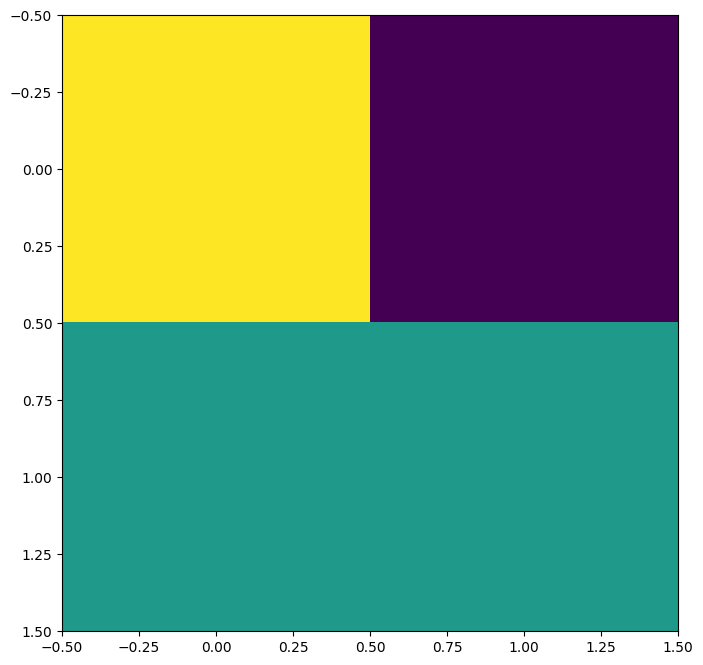

array([[14,  1],
       [ 8,  8]])

In [262]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
lg_model_final = LogisticRegression(solver='saga', penalty='elasticnet',
                                    C=1.0, l1_ratio=0.5, random_state=197).fit(X_final_training, y_train)

cm = confusion_matrix(y_test, lg_model_final.predict(X_test[:, feature_importance_top_9_idx]))
fig, ax = plt.subplots(figsize=[8, 8])
ax.imshow(cm)
ax.grid(False)
plt.show();

cm

In [263]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lg_model_final.predict(X_test[:, feature_importance_top_9_idx])))

              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.89      0.50      0.64        16

    accuracy                           0.71        31
   macro avg       0.76      0.72      0.70        31
weighted avg       0.77      0.71      0.70        31

